implementation of https://openreview.net/pdf?id=B1EA-M-0Z

Jaehoon Lee, Yasaman Bahri, Roman Novak, Samuel S. Schoenholz, Jeffrey Pennington, Jascha Sohl-Dickstei, _Deep Neural Networks as Gaussian Processes_, International Conference of Learning Representation, 2018

step 1: load data

In [24]:
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import seaborn as sns
sns.set()

In [15]:
# smaller training set coz huge matrixxes ahead
(x_train, y_train), (x_test, y_test) = mnist.load_data()

train_samples, test_samples = 11000, 1100
train_idx = np.random.randint(0, x_train.shape[0], train_samples)
test_idx = np.random.randint(0, x_test.shape[0], test_samples)

x_train, y_train = x_train[train_idx], y_train[train_idx]
x_test, y_test = x_test[test_idx], y_test[test_idx]

# create onehot labels
def onehottize(labels, num_classes):
    def onehottize_one(y):
        vec = np.zeros(num_classes)
        vec[y] = 1
        return vec

    return np.array([onehottize_one(c) for c in labels])

y_train = onehottize(y_train, 10)
y_test = onehottize(y_test, 10)

step 2: normalize inputs to be vectors, have zero mean and identical norm (1)

In [8]:
def normalize(mat):
    # flatten
    xt = mat.reshape((mat.shape[0], -1))
    
    # remove mean
    xt = xt.T - xt.T.mean(axis=0)
    
    # normalize by length
    xt = xt / np.sqrt((xt**2).sum(axis=0))
    
    return xt.T

sanity check

In [9]:
assert np.allclose(normalize(x_train), normalize(normalize(x_train)))

In [10]:
x_train = normalize(x_train)
x_test = normalize(x_test)

step 3: compute gp prior with recursion using ReLU activation function (eq. 11). the vectorized implementation computes these formulas:

$$
K^0=\sigma_b^2+\sigma_w^2\cdot \frac{XX^\intercal}{d}
$$
$$
A^\ell = \sqrt{\text{diag}(K^{\ell})\cdot\text{diag}(K^\ell)^\intercal}
$$
$$
B^\ell = \frac{K^\ell}{A^\ell}
$$
$$
\theta^\ell=\cos^{-1}(B)
$$
$$
K^\ell=\sigma_b^2+\frac{\sigma_w^2}{2\pi}\cdot A^{\ell-1}\cdot\left(\sin(\theta^{\ell-1})+(\pi-\theta^{\ell-1})\cdot B^{\ell-1}\right)
$$

where all matrix operations are element-wise, except for the vector outer product in $A^\ell$ and the matrix multipliaction in $K^0$

In [11]:
def compute_covariance(data_x, num_layers, var_b=1, var_w=1):
    kl = var_b + var_w * data_x.dot(data_x.T) / data_x.shape[1]
    
    for i in range(num_layers):
        dk = np.diag(kl).reshape(-1, 1)
        A = np.sqrt(dk.dot(dk.T))
        B = kl / A
        theta = np.arccos(B)
        kl = var_b + var_w / (2 * np.pi) * A * (
            np.sin(theta)
            + (np.pi - theta) * B
        )
    
    return kl


reproducing figure 5 as sanity check

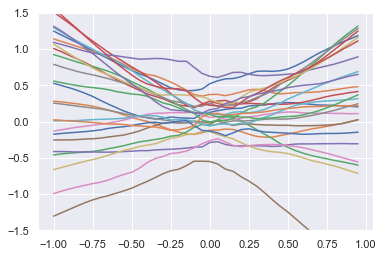

In [12]:
sample_x = np.arange(-1, 1, 0.05).reshape(-1, 1)
sample_cov = compute_covariance(sample_x, 10, var_b=0.01, var_w=1.8)

plt.ylim(-1.5, 1.5)
for _ in range(25):
    xx = np.random.multivariate_normal(np.zeros(sample_x.shape[0]), sample_cov)
    plt.plot(sample_x, xx)

step 5: fit the gaussian process (eq. 8 and eq. 9)

every output neuron has a corresponding gaussian process, and the output values are one-hot regression targets (see section 9.1)

In [13]:
def nnet_train_predict(train_samples, labels, test_samples, num_layers=10,
                       var_b=0.1, var_w=2, var_noise=0.01):
    
    n_train, _ = train_samples.shape
    
    # compute covariances
    all_data = np.vstack([train_samples, test_samples])
    kk = compute_covariance(all_data, num_layers, var_b, var_w)
    k_test_train = kk[n_train:, :n_train]
    k_train_train = kk[:n_train, :n_train]
    k_test_test = kk[n_train:, n_train:]
    
    # compute prediction for every output class (at the same time)
    return k_test_train.dot(
        np.linalg.inv(k_train_train + var_noise * np.eye(n_train))
    ).dot(labels)

In [9]:
preds = nnet_train_predict(x_train, y_train - 0.1, x_test)

compute mse

In [10]:
np.mean((preds - (y_test - 0.1))**2)

0.02664025160123632

compute accuracy

In [11]:
np.sum(np.argmax(preds, axis=1) == np.argmax(y_test, axis=1)) / y_test.shape[0]

0.9127272727272727

# yes but does it scale

In [48]:
def test_size(train_count, test_count):
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    train_idx = np.random.randint(0, x_train.shape[0], train_count)
    test_idx = np.random.randint(0, x_test.shape[0], test_count)

    x_train, y_train = x_train[train_idx], y_train[train_idx]
    x_test, y_test = x_test[test_idx], y_test[test_idx]

    y_train = onehottize(y_train, 10)
    y_test = onehottize(y_test, 10)

    x_train = normalize(x_train)
    x_test = normalize(x_test)

    preds = nnet_train_predict(x_train, y_train - 0.1, x_test)
    acc = np.sum(np.argmax(preds, axis=1) == np.argmax(y_test, axis=1)) / y_test.shape[0]
    
    return acc


results = []
for cnt in [10, 25, 50, 100, 250, 500, 1000, 2500, 5000, 10000]:
    for i in range(10):
        tstart = time.time()
        acc = test_size(cnt, 1000)
        tend = time.time()    

        results.append((cnt, i + 1, tend - tstart, 100 * acc))
    print('%d samples, trial %d - %.3f seconds, %.3f accuracy' % results[-1])

10 samples, trial 10 - 0.678 seconds, 14.400 accuracy
25 samples, trial 10 - 0.674 seconds, 36.300 accuracy


C:\Users\edo\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in arccos
  


50 samples, trial 10 - 0.736 seconds, 56.500 accuracy
100 samples, trial 10 - 0.722 seconds, 61.000 accuracy
250 samples, trial 10 - 0.860 seconds, 74.700 accuracy
500 samples, trial 10 - 1.132 seconds, 84.100 accuracy
1000 samples, trial 10 - 1.850 seconds, 81.800 accuracy
2500 samples, trial 10 - 5.792 seconds, 90.100 accuracy
5000 samples, trial 10 - 17.466 seconds, 88.600 accuracy
10000 samples, trial 10 - 71.769 seconds, 91.600 accuracy


In [38]:
resdf = pd.DataFrame(results, columns=['samples', 'trial', 'seconds', 'accuracy'])

In [39]:
resdf.groupby(
    'samples'
)[
    ['seconds', 'accuracy']
].apply(lambda x: pd.DataFrame([x.mean(), x.std()], index=['mean', 'std']).T)

mean        std
samples                               
10      seconds    0.698931   0.032528
        accuracy  16.020000   4.855615
25      seconds    0.750431   0.020739
        accuracy  33.040000  10.652605
50      seconds    0.771738   0.020818
        accuracy  47.280000  10.452368
100     seconds    0.755581   0.016473
        accuracy  65.600000   3.243455
250     seconds    0.917746   0.016902
        accuracy  76.080000   3.264506
500     seconds    1.174661   0.019072
        accuracy  81.160000   1.591540
1000    seconds    1.888553   0.015036
        accuracy  84.480000   0.903881
2500    seconds    5.562335   0.126048
        accuracy  88.720000   1.370036
5000    seconds   18.121375   0.615536
        accuracy  88.700000   0.916515
10000   seconds   80.058489   1.378709
        accuracy  91.640000   0.856154

# in tensorflow!

todo

# optimization of hyperparameters

In [12]:
bounds = [dict(zip(['name', 'type', 'domain'], spec)) for spec in [
    ('num_layers', 'discrete', list(range(1, 21))),
    ('var_b', 'continuous', (-20, 8)),
    ('var_w', 'continuous', (-20, 8)),
    ('var_noise', 'continuous', (-20, 8)),
]]


history = []
def target(params):
    num_layers, var_b, var_w, var_noise = params[0]
    print(num_layers, var_b, var_w, var_noise)
    
    try:
        preds = nnet_train_predict(
            x_train, y_train - 0.1, x_test,
            int(num_layers), 2**var_b, 2**var_w, 2**var_noise,
        )
    except Exception as exc:
        import traceback
        traceback.print_exc()
        mse, acc = 100, 0
    else:
        mse = np.mean((preds - (y_test - 0.1))**2)
        acc = np.sum(np.argmax(preds, axis=1) == np.argmax(y_test, axis=1)) / y_test.shape[0]

    print(mse, acc)
    history.append((num_layers, var_b, var_w, var_noise, mse, acc))
    print('--------')
    return mse


import GPyOpt
bopt = GPyOpt.methods.BayesianOptimization(
    target, bounds,
    model_type='GP_MCMC',
    acquisition_type='EI_MCMC',
)

bopt.run_optimization(max_iter=1000)
bopt.fx_opt

7.0 -6.510581904011234 -18.502523727625057 6.739808372365928
0.08996343117947098 0.11181818181818182
--------
4.0 -2.385714801041157 -15.654795975248044 -11.748630190464922
0.08994789917578846 0.11181818181818182
--------
3.0 -2.8385453372939367 5.665523942118256 1.1765138212080224
0.009263180600648483 0.9745454545454545
--------
7.0 -10.797292584460447 -7.247487952924601 -17.196367443877502
0.08994789919095006 0.11181818181818182
--------
8.0 -3.407978205414878 -19.97542605285897 1.9084193267035872


reconstraining parameters GP_regression.rbf
reconstraining parameters GP_regression.Gaussian_noise.variance


0.08994795811905477 0.11181818181818182
--------
3.0 -2.8385355457695547 5.6655688514054425 1.1765388646375252
0.009263171231225789 0.9745454545454545
--------
3.0 -2.931818476436438 6.548251078285002 1.9221906224513383
0.009128286040863274 0.9745454545454545
--------
2.0 -1.1990104443249214 7.429461929559323 0.6326148056782557
0.009476865215948035 0.9727272727272728
--------
8.0 0.9261801010149994 8.0 2.40589004826074


Traceback (most recent call last):
  File "<ipython-input-12-c07beb989505>", line 17, in target
    int(num_layers), 2**var_b, 2**var_w, 2**var_noise,
  File "<ipython-input-8-54d6b5a68608>", line 15, in nnet_train_predict
    np.linalg.inv(k_train_train + var_noise * np.eye(n_train))
  File "C:\Users\edo\Anaconda3\lib\site-packages\numpy\linalg\linalg.py", line 532, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "C:\Users\edo\Anaconda3\lib\site-packages\numpy\linalg\linalg.py", line 89, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.linalg.LinAlgError: Singular matrix


100 0
--------
1.0 -3.888516141165767 6.820050970373891 0.5750623438068074
0.012777909217533207 0.9618181818181818
--------
1.0 -3.193079840797234 2.1372866705320943 3.0545427275070565
0.06617874546343522 0.7909090909090909
--------
7.0 -7.69770055197537 -11.421414201200482 -12.022689186774326
0.08994789924702784 0.11181818181818182
--------
1.0 -4.330485325384541 2.71575747825629 -7.524919290050208
0.014927442881565216 0.9509090909090909
--------
7.0 -8.138706462356597 -9.286279381646933 -15.233237271926301
0.08994789918432707 0.11181818181818182
--------
1.0 -0.6109909825143099 3.5185280996453843 -1.8900074571895569
0.032431903520784996 0.89
--------
1.0 -7.4056018135309705 6.479726323320342 5.338605606105441
0.02704876269190317 0.9136363636363637
--------
4.0 -8.212834668399731 -2.99564822611025 -11.098870110162006
0.08978339593013462 0.11181818181818182
--------
1.0 -3.882743742535087 -8.75224504266908 -11.300056443793626
0.0896594647484208 0.11181818181818182
--------
2.0 -1.73053

Traceback (most recent call last):
  File "<ipython-input-12-c07beb989505>", line 17, in target
    int(num_layers), 2**var_b, 2**var_w, 2**var_noise,
  File "<ipython-input-8-54d6b5a68608>", line 15, in nnet_train_predict
    np.linalg.inv(k_train_train + var_noise * np.eye(n_train))
  File "C:\Users\edo\Anaconda3\lib\site-packages\numpy\linalg\linalg.py", line 532, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "C:\Users\edo\Anaconda3\lib\site-packages\numpy\linalg\linalg.py", line 89, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.linalg.LinAlgError: Singular matrix


100 0
--------
1.0 -7.0465045387062535 8.0 -20.0
0.010451958376504665 0.9718181818181818
--------
20.0 -19.583372869412756 -20.0 -20.0
0.08994790027708582 0.11181818181818182
--------
1.0 -20.0 -5.6953458529005365 -0.9342227915714814
0.0899882294912949 0.11181818181818182
--------
20.0 8.0 -20.0 -4.011385082354544
0.08994789917392736 0.11181818181818182
--------
20.0 0.5067892478469123 -8.176292618189652 -20.0
0.08994789916456257 0.11181818181818182
--------
20.0 -4.734038459715981 -20.0 -12.30373063943135
0.0899478991813063 0.11181818181818182
--------
1.0 8.0 -20.0 8.0
0.08994790064659318 0.11181818181818182
--------
20.0 -20.0 -20.0 -4.935957307895406
0.08998073121417434 0.11181818181818182
--------
14.0 6.291121598289048 -14.009275666459104 -12.555126665682476
0.08994789919439701 0.11181818181818182
--------
1.0 8.0 -20.0 -6.112048108645419
0.08994789917357757 0.11181818181818182
--------
20.0 8.0 -20.0 8.0
0.08994790064659378 0.11181818181818182
--------
10.0 -20.0 -20.0 -12.53124

Traceback (most recent call last):
  File "<ipython-input-12-c07beb989505>", line 17, in target
    int(num_layers), 2**var_b, 2**var_w, 2**var_noise,
  File "<ipython-input-8-54d6b5a68608>", line 15, in nnet_train_predict
    np.linalg.inv(k_train_train + var_noise * np.eye(n_train))
  File "C:\Users\edo\Anaconda3\lib\site-packages\numpy\linalg\linalg.py", line 532, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "C:\Users\edo\Anaconda3\lib\site-packages\numpy\linalg\linalg.py", line 89, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.linalg.LinAlgError: Singular matrix


100 0
--------
20.0 -5.237482025414013 -13.650998766997747 -20.0
0.08994789917320066 0.11181818181818182
--------
20.0 -20.0 -20.0 8.0
0.08999999639412531 0.11181818181818182
--------
11.0 0.4971262652257042 -13.606867436415543 -20.0
0.08994789915896804 0.11181818181818182
--------
1.0 -12.767717881406615 -0.41975318735962686 -20.0
0.010340514417383186 0.9709090909090909
--------
20.0 -5.177328070162622 -20.0 3.119548429113474
0.08994837724073312 0.11181818181818182
--------
1.0 -20.0 8.0 8.0
0.025192325865515237 0.9163636363636364
--------
1.0 8.0 -20.0 -20.0
0.0899478995757142 0.11181818181818182
--------
1.0 -20.0 -20.0 8.0
0.08999999639412523 0.11181818181818182
--------
1.0 -20.0 -20.0 -6.466573886930496
0.08996596390188223 0.11181818181818182
--------
1.0 8.0 -9.907794661525207 -10.112877742261432
0.089922175278913 0.11181818181818182
--------
1.0 -8.649555691480616 8.0 1.4914322376586522
0.011403357419695705 0.9645454545454546
--------
1.0 -20.0 -8.496187095660847 -20.0
0.053633

Traceback (most recent call last):
  File "<ipython-input-12-c07beb989505>", line 17, in target
    int(num_layers), 2**var_b, 2**var_w, 2**var_noise,
  File "<ipython-input-8-54d6b5a68608>", line 8, in nnet_train_predict
    kk = compute_covariance(all_data, num_layers, var_b, var_w)
  File "<ipython-input-6-a0c77018d1ec>", line 11, in compute_covariance
    + (np.pi - theta) * B
MemoryError


100 0
--------
20.0 -4.945141495311703 -18.918037046726127 -20.0


Traceback (most recent call last):
  File "<ipython-input-12-c07beb989505>", line 17, in target
    int(num_layers), 2**var_b, 2**var_w, 2**var_noise,
  File "<ipython-input-8-54d6b5a68608>", line 8, in nnet_train_predict
    kk = compute_covariance(all_data, num_layers, var_b, var_w)
  File "<ipython-input-6-a0c77018d1ec>", line 11, in compute_covariance
    + (np.pi - theta) * B
MemoryError


100 0
--------


KeyboardInterrupt: 

so it seems like the best accuracy is 0.9755, with a MSE of 0.008821